In [1]:
# Imports
# ALL
import keras
import os
import random

import os
# AS
# %matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# FROM
from concurrent.futures import ProcessPoolExecutor
from contextlib import redirect_stdout
from keras.models import Sequential
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, GlobalAveragePooling3D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


###########
import os
import sys
import torch

# AS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# FROM
from PIL import Image
from PIL import UnidentifiedImageError

/opt/homebrew/lib/python3.11/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# tf.keras.backend.clear_session()

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow version: 2.13.0
Num GPUs Available:  0


In [3]:
##### pytorch version and GPU
print("PyTorch version:", torch.__version__)
print("MPS Available: ", torch.backends.mps.is_available()) # torch.cuda.is_available()
# print("MPS Version: ", torch.backends.mps.__version__)
print("Number of GPUs: ", torch.cuda.device_count())
# print("Current GPU Device: ", torch.backends.mps.current_device())

# activate the mps
# torch.backends.mps.enable_non_blocking()
# torch.backends.mps.current_device()

# Print available devices, MPS should be among them
print(torch.backends.mps.is_available())

# Set device to MPS
device = torch.device("mps")
print(f"Using device: {device}")



PyTorch version: 2.1.0
MPS Available:  True
Number of GPUs:  0
True
Using device: mps


In [4]:
# import torch
# torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [5]:
# Loading Data
main_root_directory = "/Users/izzymohamed/Desktop/MLPData"
MRI_modal_directory = main_root_directory + "/MRI"
CT_modal_directory = main_root_directory + "/CT"
pet_modal_directory = main_root_directory + "/PET"
results_folder = main_root_directory + "/RESULTS"

In [6]:
# Create new folder to save the results of the model
MRI_folder_name = MRI_modal_directory.split('/')[-2] + "/" + MRI_modal_directory.split('/')[-1]
CT_folder_name = CT_modal_directory.split('/')[-2] + "/" + CT_modal_directory.split('/')[-1]
PET_folder_name = pet_modal_directory.split('/')[-2] + "/" + pet_modal_directory.split('/')[-1]

In [7]:
def collect_files_from_directories(main_root_directory):
    categories = [
        "non-demented",
        "very-mild-dementia",
        "mild-dementia",
        "moderate-dementia",
        "unknown",
    ]
    
    # Initialize an empty list to collect file info
    collected_files = []

    # Walk through the directory structure
    for root, dirs, files in os.walk(main_root_directory):
        # Check if the current folder is one of the categories
        category = os.path.basename(root)
        if category in categories:
            print(category)
            # Construct the full file paths in one go and append them
            collected_files.extend([(os.path.join(root, file), category) for file in files])
                
    print("DONE")
    
    # Convert the collected file info into a DataFrame
    df = pd.DataFrame(collected_files, columns=['FilePath', 'Category'])
    
    return df

In [8]:
collect_files_from_directories_df_mri = collect_files_from_directories(MRI_modal_directory)
collect_files_from_directories_df_ct = collect_files_from_directories(CT_modal_directory)
collect_files_from_directories_df_pet = collect_files_from_directories(pet_modal_directory)

non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
DONE
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
DONE
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
non-demented
moderate-dementia
unknown
very-mild-dementia
mild-dementia
DONE


In [9]:
# convert collect_files_from_directories_df to dictionary where Category is the key and the value is the list of file paths
def convert_df_to_dict(df):
    # Initialize an empty dictionary
    file_dict = {}
    categories = [
        "non-demented",
        "very-mild-dementia",
        "mild-dementia",
        "moderate-dementia",
        "unknown",
    ]
    # Loop through the unique categories
    for category in categories:
        # Collect the file paths for the current category
        file_dict[category] = df[df['Category'] == category]['FilePath'].values
    
    return file_dict

In [10]:
images_dict_mri = convert_df_to_dict(collect_files_from_directories_df_mri)
images_dict_ct = convert_df_to_dict(collect_files_from_directories_df_ct)
images_dict_pet = convert_df_to_dict(collect_files_from_directories_df_pet)

In [11]:
# Now you can access the images using the keys in images_dict_mri and images_dict_ct
non_demented_mri = images_dict_mri['non-demented'] if 'non-demented' in images_dict_mri else []
very_mild_demented_mri = images_dict_mri['very-mild-dementia'] if 'very-mild-dementia' in images_dict_mri else []
mild_demented_mri = images_dict_mri['mild-dementia'] if 'mild-dementia' in images_dict_mri else []
moderate_demented_mri = images_dict_mri['moderate-dementia'] if 'moderate-dementia' in images_dict_mri else []
unknown_mri = images_dict_mri['unknown'] if 'unknown' in images_dict_mri else []

In [12]:
non_demented_ct = images_dict_ct['non-demented'] if 'non-demented' in images_dict_ct else []
very_mild_demented_ct = images_dict_ct['very-mild-dementia'] if 'very-mild-dementia' in images_dict_ct else []
mild_demented_ct = images_dict_ct['mild-dementia'] if 'mild-dementia' in images_dict_ct else []
moderate_demented_ct = images_dict_ct['moderate-dementia'] if 'moderate-dementia' in images_dict_ct else []
unknown_ct = images_dict_ct['unknown'] if 'unknown' in images_dict_ct else []

In [13]:
# ADD the pet data
non_demented_pet = images_dict_pet['non-demented'] if 'non-demented' in images_dict_pet else []
very_mild_demented_pet = images_dict_pet['very-mild-dementia'] if 'very-mild-dementia' in images_dict_pet else []
mild_demented_pet = images_dict_pet['mild-dementia'] if 'mild-dementia' in images_dict_pet else []
moderate_demented_pet = images_dict_pet['moderate-dementia'] if 'moderate-dementia' in images_dict_pet else []

In [14]:
# If you need to print the count for each category:
for key, value in images_dict_mri.items():
    print(f"{key} (MRI): {len(value)} images")

for key, value in images_dict_ct.items():
    print(f"{key} (CT): {len(value)} images")

for key, value in images_dict_pet.items():
    print(f"{key} (PET): {len(value)} images")

non-demented (MRI): 410159 images
very-mild-dementia (MRI): 121846 images
mild-dementia (MRI): 43249 images
moderate-dementia (MRI): 14457 images
unknown (MRI): 52765 images
non-demented (CT): 64899 images
very-mild-dementia (CT): 7852 images
mild-dementia (CT): 3480 images
moderate-dementia (CT): 2520 images
unknown (CT): 806 images
non-demented (PET): 76242 images
very-mild-dementia (PET): 8296 images
mild-dementia (PET): 4585 images
moderate-dementia (PET): 4261 images
unknown (PET): 464 images


In [15]:
print(f"Non-demented: {len(non_demented_mri)}")
print(f"Very mild dementia: {len(very_mild_demented_mri)}")
print(f"Mild dementia: {len(mild_demented_mri)}")
print(f"Moderate dementia: {len(moderate_demented_mri)}")

Non-demented: 410159
Very mild dementia: 121846
Mild dementia: 43249
Moderate dementia: 14457


In [16]:
print(f"Non-demented: {len(non_demented_ct)}")
print(f"Very mild dementia: {len(very_mild_demented_ct)}")
print(f"Mild dementia: {len(mild_demented_ct)}")
print(f"Moderate dementia: {len(moderate_demented_ct)}")

Non-demented: 64899
Very mild dementia: 7852
Mild dementia: 3480
Moderate dementia: 2520


In [17]:
print(f"Non-demented: {len(non_demented_pet)}")
print(f"Very mild dementia: {len(very_mild_demented_pet)}")
print(f"Mild dementia: {len(mild_demented_pet)}")
print(f"Moderate dementia: {len(moderate_demented_pet)}")

Non-demented: 76242
Very mild dementia: 8296
Mild dementia: 4585
Moderate dementia: 4261


In [18]:
def display_images_with_text(images, category_name,):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Images from {category_name}", fontsize=16)

    display_count = 0 # Initialize a counter for displayed images

    if len(images) == 0:
        print("No images to display")
        return
    
    # Ensure to display up to 3 images only
    for i in range(min(3, len(images))):
        if display_count < 3: # Check if less than 3 images have been displayed
            img_path = images[i]
            img = Image.open(img_path)
            plt.subplot(1, 3, display_count + 1) # Use display_count for subplot indexing
            plt.imshow(img)
            plt.axis('off')
            
            # Add text indicating the category
            plt.text(0, -10, f"{category_name.split()[0]} {display_count + 1}", color='white', fontsize=12, weight='bold', ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.7))
            
            display_count += 1 # Increment the displayed images counter

    plt.show()

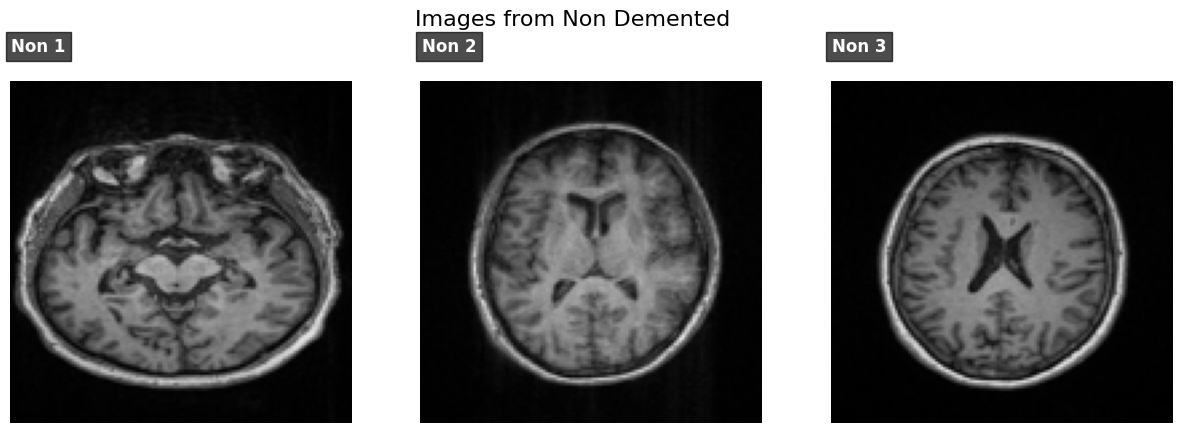

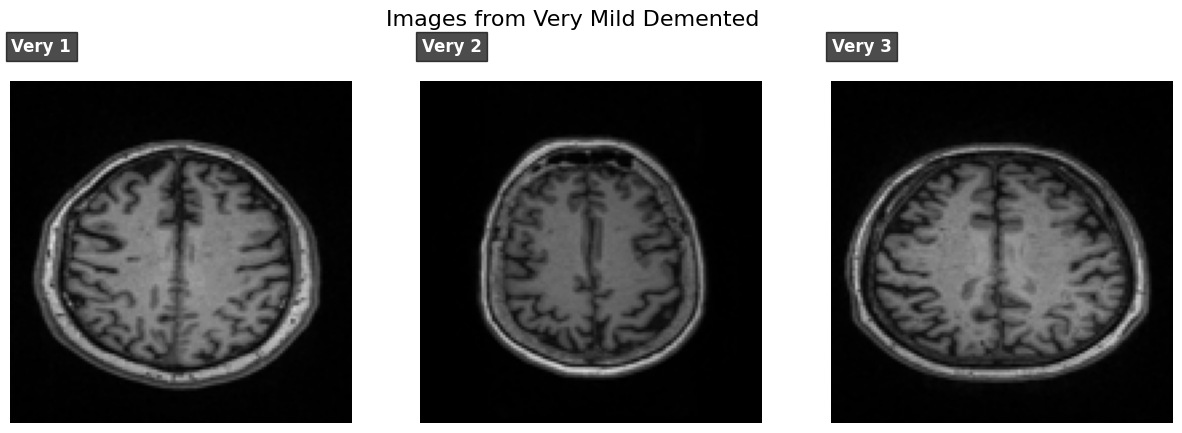

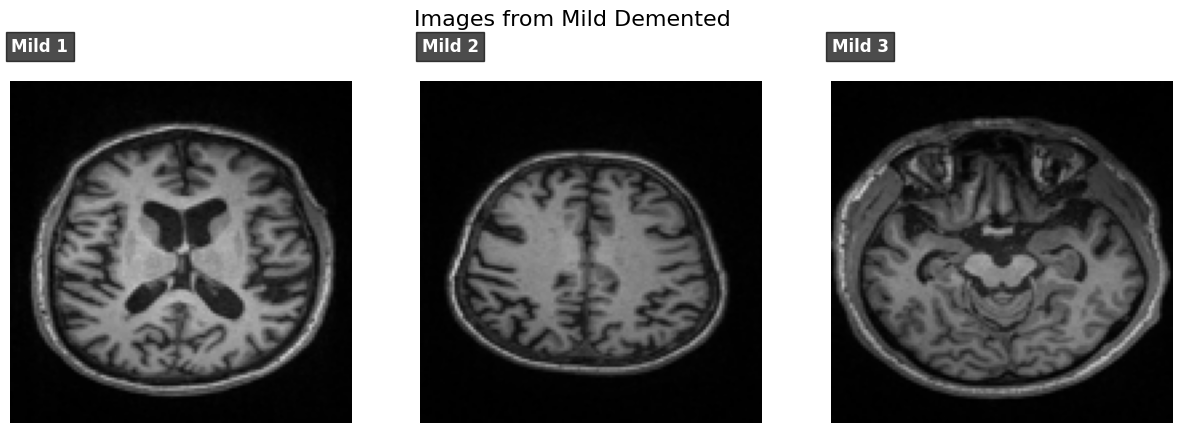

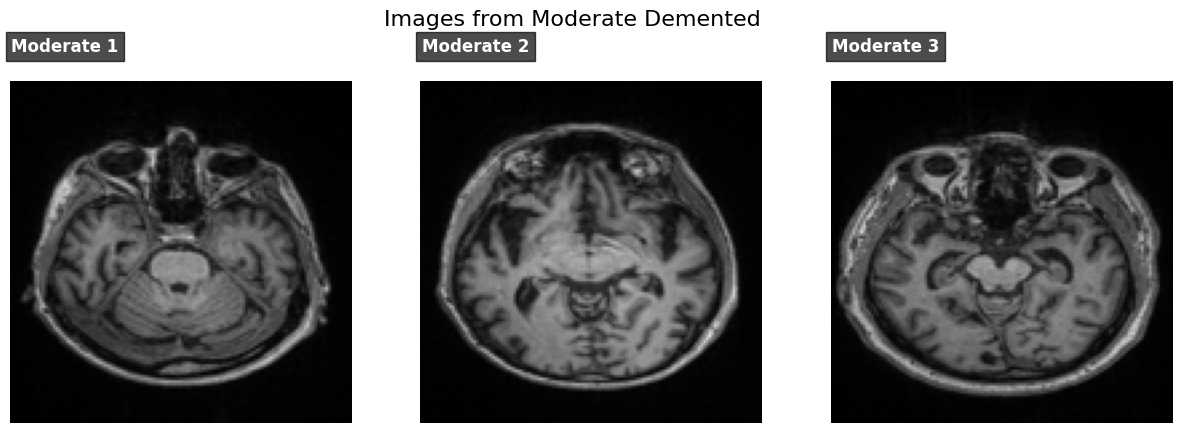

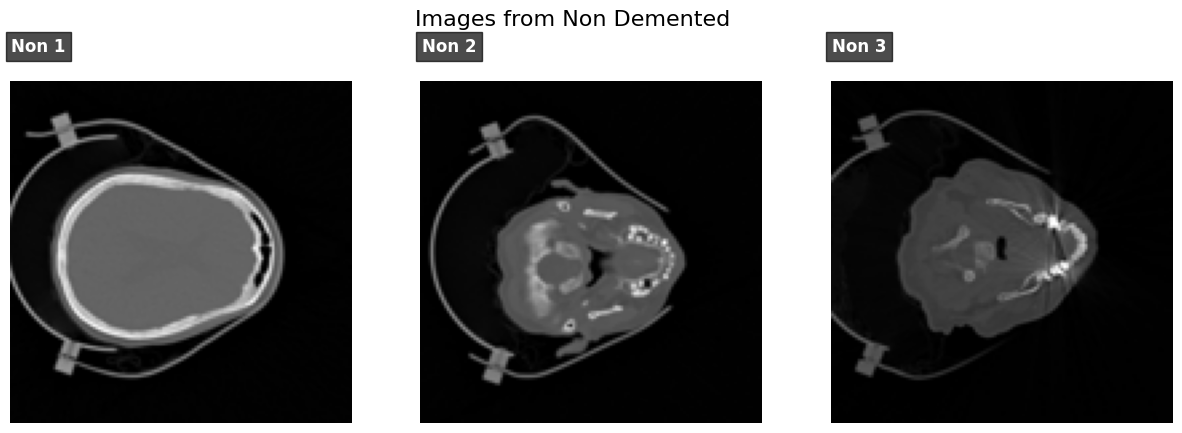

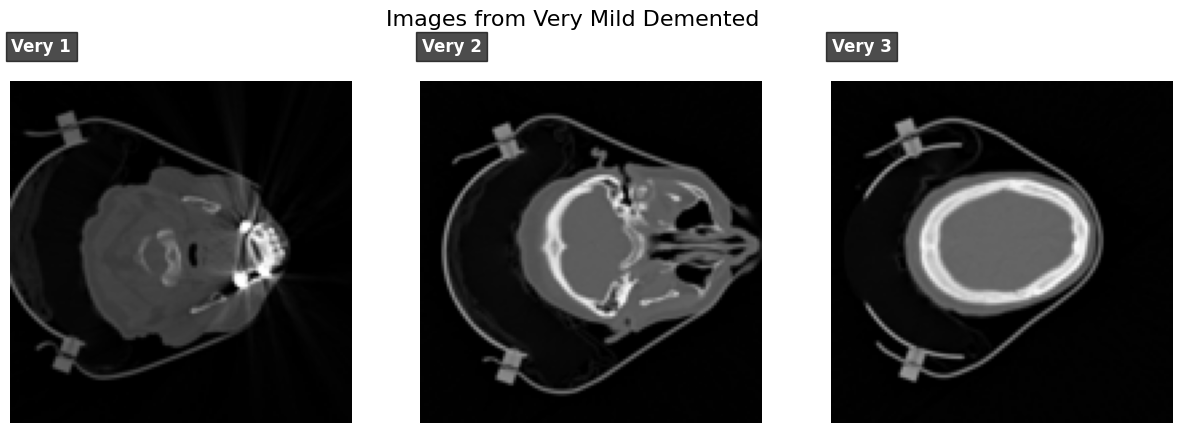

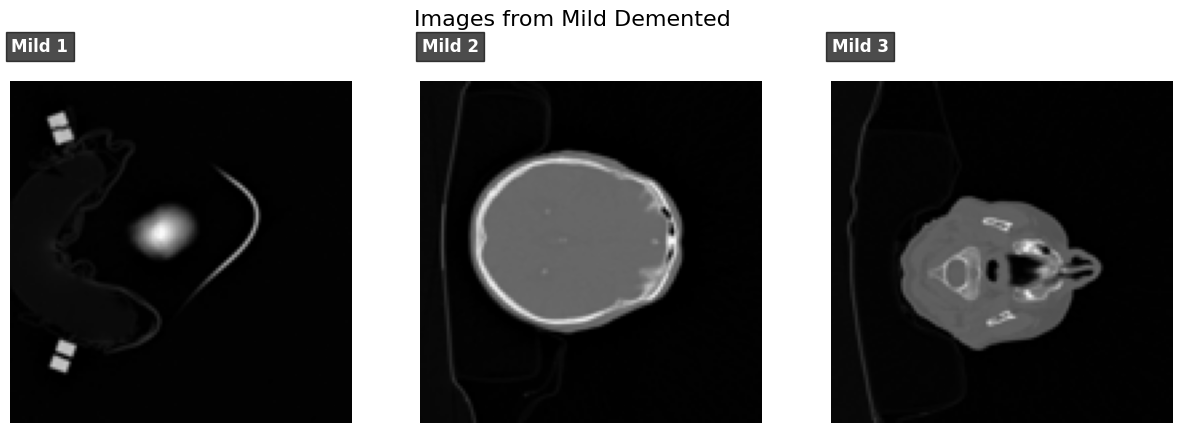

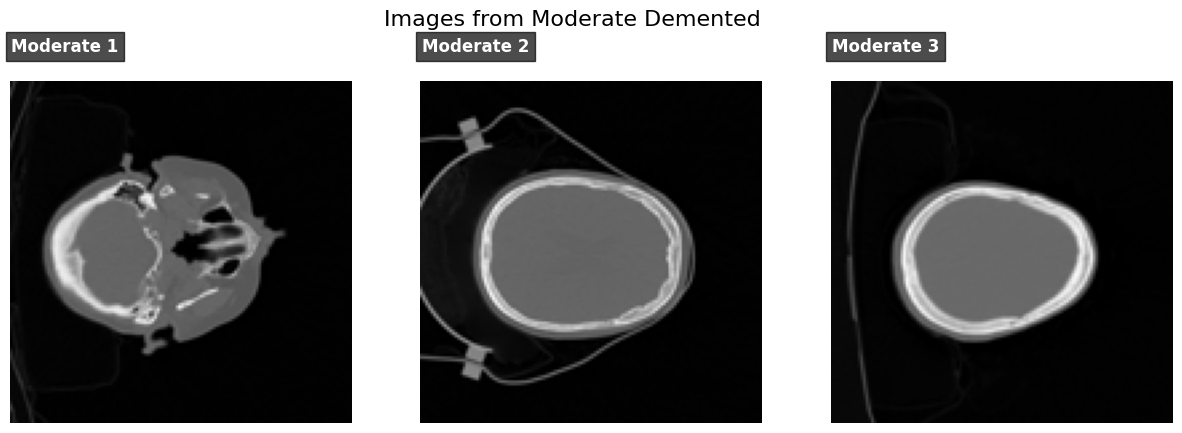

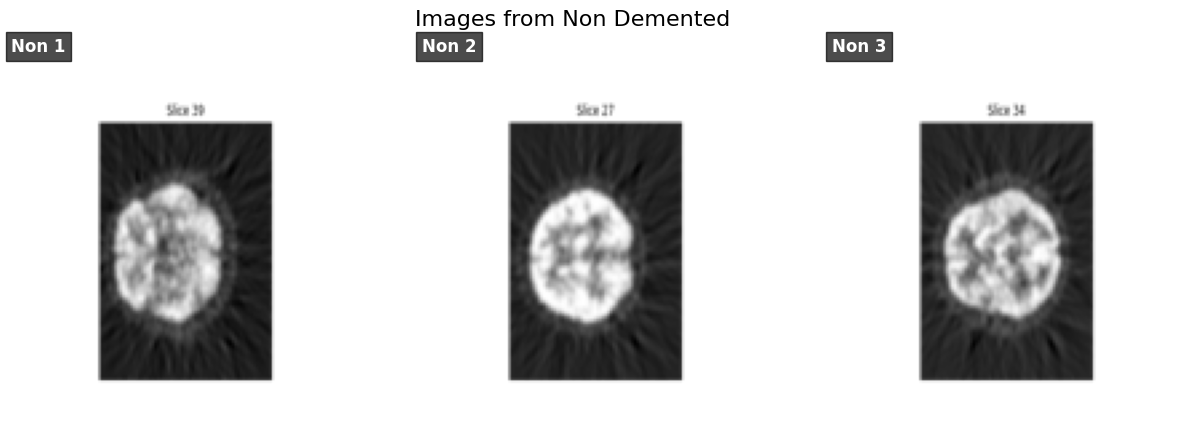

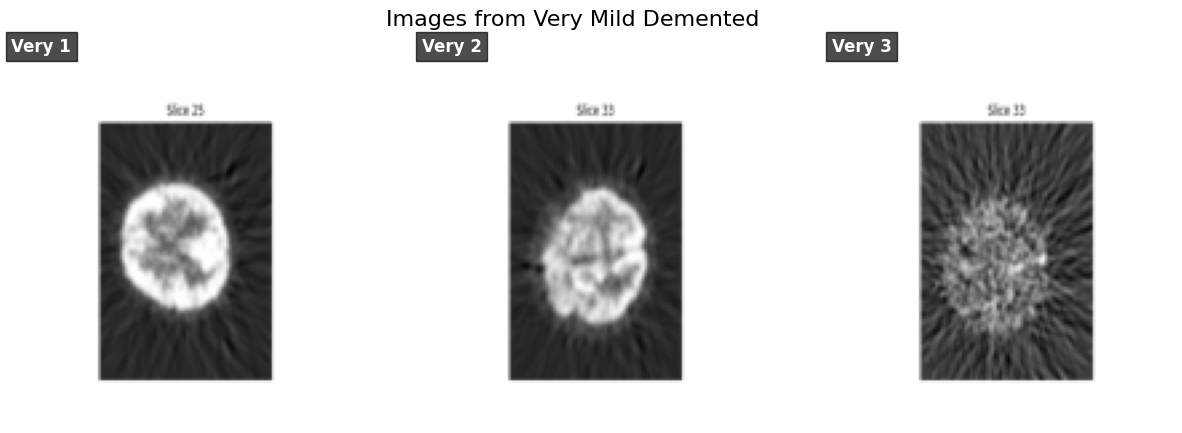

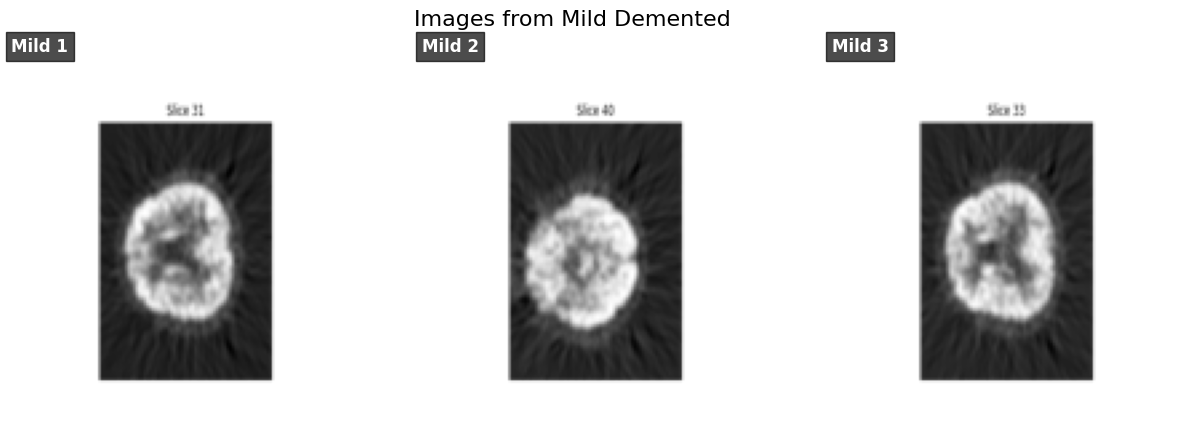

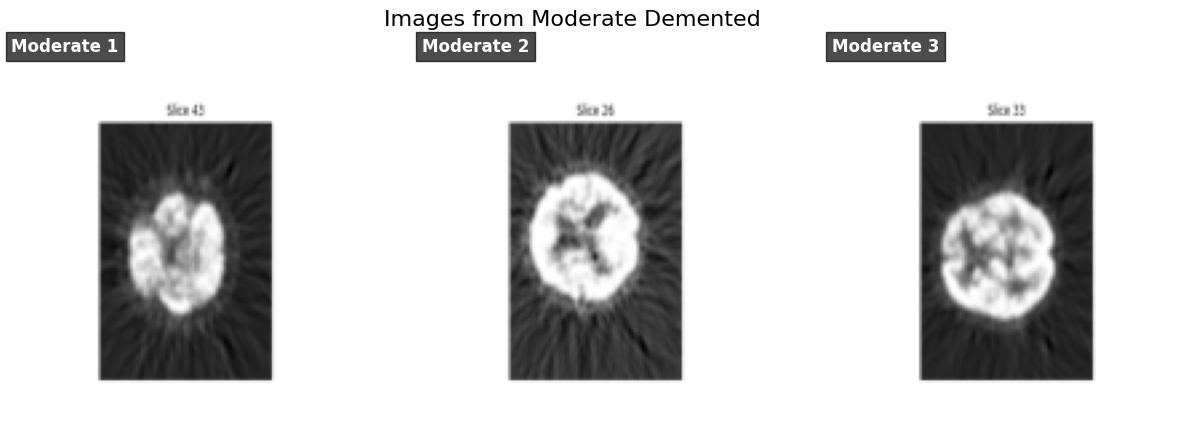

In [19]:
# Display images with text for each category
display_images_with_text(non_demented_mri, "Non Demented")
display_images_with_text(very_mild_demented_mri, "Very Mild Demented")
display_images_with_text(mild_demented_mri, "Mild Demented")
display_images_with_text(moderate_demented_mri, "Moderate Demented")
display_images_with_text(non_demented_ct, "Non Demented")
display_images_with_text(very_mild_demented_ct, "Very Mild Demented")
display_images_with_text(mild_demented_ct, "Mild Demented")
display_images_with_text(moderate_demented_ct, "Moderate Demented")
display_images_with_text(non_demented_pet, "Non Demented")
display_images_with_text(very_mild_demented_pet, "Very Mild Demented")
display_images_with_text(mild_demented_pet, "Mild Demented")
display_images_with_text(moderate_demented_pet, "Moderate Demented")


In [20]:
# Data Preprocessing
# Set seed for random sampling
random.seed(42)

def train_test_split_fun(class_df):
    if len(class_df) > 0:
        return train_test_split(class_df, test_size=0.2, random_state=42)
    else:
        return [], []

In [21]:
# Split off a test set for the moderate_demented class
moderate_demented_train_mri, moderate_demented_test_mri = train_test_split_fun(moderate_demented_mri)
moderate_demented_train_ct, moderate_demented_test_ct = train_test_split_fun(moderate_demented_ct)
moderate_demented_train_pet, moderate_demented_test_pet = train_test_split_fun(moderate_demented_pet)


In [22]:
# Split off a test set for the mild_demented class
mild_demented_train_mri, mild_demented_test_mri = train_test_split_fun(mild_demented_mri)
mild_demented_train_ct, mild_demented_test_ct = train_test_split_fun(mild_demented_ct)
mild_demented_train_pet, mild_demented_test_pet = train_test_split_fun(mild_demented_pet)



In [23]:
# Split off a test set for the very_mild_demented class
very_mild_demented_train_mri, very_mild_demented_test_mri = train_test_split_fun(very_mild_demented_mri)
very_mild_demented_train_ct, very_mild_demented_test_ct = train_test_split_fun(very_mild_demented_ct)
very_mild_demented_train_pet, very_mild_demented_test_pet = train_test_split_fun(very_mild_demented_pet)


In [24]:
# Split off a test set for the non_demented class
non_demented_train_mri, non_demented_test_mri = train_test_split_fun(non_demented_mri)
non_demented_train_ct, non_demented_test_ct = train_test_split_fun(non_demented_ct)
non_demented_train_pet, non_demented_test_pet = train_test_split_fun(non_demented_pet)


In [25]:
# Check number of train images per category
print(len(non_demented_train_mri))
print(len(very_mild_demented_train_mri))
print(len(mild_demented_train_mri))
print(len(moderate_demented_train_mri))
print(len(non_demented_train_ct))
print(len(very_mild_demented_train_ct))
print(len(mild_demented_train_ct))
print(len(moderate_demented_train_ct))
print(len(non_demented_train_pet))
print(len(very_mild_demented_train_pet))
print(len(mild_demented_train_pet))
print(len(moderate_demented_train_pet))

328127
97476
34599
11565
51919
6281
2784
2016
60993
6636
3668
3408


In [26]:
def random_choices_sample(dataset, target_samples):
    if len(dataset) == 0:
        # return a list of zeros if the dataset is empty
        return [0] * target_samples
    else:
        if len(dataset) < target_samples:
            # Oversample small classes
            return random.choices(dataset, k=target_samples)
        else: 
            # Undersample large classes
            return random.sample(list(dataset), k=target_samples)

In [27]:
# Specify the target number of samples for each class
train_target_samples = 5000

In [28]:
# Oversample small classes
moderate_demented_samp_mri = random_choices_sample(moderate_demented_train_mri, train_target_samples)
mild_demented_samp_mri = random_choices_sample(mild_demented_train_mri, train_target_samples)
very_mild_demented_samp_mri = random_choices_sample(very_mild_demented_train_mri, train_target_samples)
non_demented_samp_mri = random_choices_sample(non_demented_train_mri, train_target_samples)

In [29]:
# same for the ct
moderate_demented_samp_ct = random_choices_sample(moderate_demented_train_ct, train_target_samples)
mild_demented_samp_ct = random_choices_sample(mild_demented_train_ct, train_target_samples)
very_mild_demented_samp_ct = random_choices_sample(very_mild_demented_train_ct, train_target_samples)
non_demented_samp_ct = random_choices_sample(non_demented_train_ct, train_target_samples)

In [30]:
#same for the pet
moderate_demented_samp_pet = random_choices_sample(moderate_demented_train_pet, train_target_samples)
mild_demented_samp_pet = random_choices_sample(mild_demented_train_pet, train_target_samples)
very_mild_demented_samp_pet = random_choices_sample(very_mild_demented_train_pet, train_target_samples)
non_demented_samp_pet = random_choices_sample(non_demented_train_pet, train_target_samples)

In [31]:
# Check results
print(len(non_demented_samp_mri))
print(len(non_demented_samp_ct))
print(len(very_mild_demented_samp_mri))
print(len(very_mild_demented_samp_ct))
print(len(mild_demented_samp_mri))
print(len(mild_demented_samp_ct))
print(len(moderate_demented_samp_mri))
print(len(moderate_demented_samp_ct))
print(len(non_demented_samp_pet))
print(len(very_mild_demented_samp_pet))
print(len(mild_demented_samp_pet))
print(len(moderate_demented_samp_pet))

5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


In [32]:
# Check the number of test images per category
print(len(non_demented_test_mri))
print(len(very_mild_demented_test_mri))
print(len(mild_demented_test_mri))
print(len(moderate_demented_test_mri))

82032
24370
8650
2892


In [33]:
# ct
print(len(non_demented_test_ct))
print(len(very_mild_demented_test_ct))
print(len(mild_demented_test_ct))
print(len(moderate_demented_test_ct))

12980
1571
696
504


In [34]:
# pet
print(len(non_demented_test_pet))
print(len(very_mild_demented_test_pet))
print(len(mild_demented_test_pet))
print(len(moderate_demented_test_pet))

15249
1660
917
853


In [35]:
# Specify the target number of samples for each class
test_target_samples = 100

In [36]:
# Undersample large classes
mild_demented_test_mri = random_choices_sample(mild_demented_test_mri, test_target_samples)
mild_demented_test_ct = random_choices_sample(mild_demented_test_ct, test_target_samples)
mild_demented_test_pet = random_choices_sample(mild_demented_test_pet, test_target_samples)
very_mild_demented_test_mri = random_choices_sample(very_mild_demented_test_mri, test_target_samples)
very_mild_demented_test_ct = random_choices_sample(very_mild_demented_test_ct, test_target_samples)
very_mild_demented_test_pet = random_choices_sample(very_mild_demented_test_pet, test_target_samples)
non_demented_test_mri = random_choices_sample(non_demented_test_mri, test_target_samples)
non_demented_test_ct = random_choices_sample(non_demented_test_ct, test_target_samples)
non_demented_test_pet = random_choices_sample(non_demented_test_pet, test_target_samples)
moderate_demented_test_mri = random_choices_sample(moderate_demented_test_mri, test_target_samples)
moderate_demented_test_ct = random_choices_sample(moderate_demented_test_ct, test_target_samples)
moderate_demented_test_pet = random_choices_sample(moderate_demented_test_pet, test_target_samples)

In [37]:
# print the results from the test set
print(len(non_demented_test_mri))
print(len(very_mild_demented_test_mri))
print(len(mild_demented_test_mri))
print(len(moderate_demented_test_mri))
print(len(non_demented_test_ct))
print(len(very_mild_demented_test_ct))
print(len(mild_demented_test_ct))
print(len(moderate_demented_test_ct))
print(len(non_demented_test_pet))
print(len(very_mild_demented_test_pet))
print(len(mild_demented_test_pet))
print(len(moderate_demented_test_pet))

100
100
100
100
100
100
100
100
100
100
100
100


In [38]:
# One-hot encoder for class labels 
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [39]:
# merge the mri and ct data where mri is the first item and ct is the second item
non_demented_samp = list(zip(non_demented_samp_mri, non_demented_samp_ct, non_demented_samp_pet))
very_mild_demented_samp = list(zip(very_mild_demented_samp_mri, very_mild_demented_samp_ct, very_mild_demented_samp_pet))
mild_demented_samp = list(zip(mild_demented_samp_mri, mild_demented_samp_ct, mild_demented_samp_pet))
moderate_demented_samp = list(zip(moderate_demented_samp_mri, moderate_demented_samp_ct, moderate_demented_samp_pet))

In [40]:
# merge the test sets
non_demented_test = list(zip(non_demented_test_mri, non_demented_test_ct, non_demented_test_pet))
very_mild_demented_test = list(zip(very_mild_demented_test_mri, very_mild_demented_test_ct, very_mild_demented_test_pet))
mild_demented_test = list(zip(mild_demented_test_mri, mild_demented_test_ct, mild_demented_test_pet))
moderate_demented_test = list(zip(moderate_demented_test_mri, moderate_demented_test_ct, moderate_demented_test_pet))

In [41]:
# Mapping categories to their labels
categories = {
    'non_demented_samp': 0,
    'very_mild_demented_samp': 1,
    'mild_demented_samp': 2,
    'moderate_demented_samp': 3
}

In [42]:
def process_image(path):
    if path == 0:
        return np.zeros((128, 128, 3)), path
    
    try:
        with Image.open(path) as img:
            img = img.resize((128, 128))
            img_array = np.array(img)[:,:,:3]
            if img_array.shape == (128, 128, 3):
                return img_array, path
    except IOError as e:
        print(f"Unable to process image file: {path} due to {e}")
    return None, path

In [43]:
def update_results(processed_data, data, result, label):
    for img_array, path in processed_data:
        if img_array is not None:
            data.append(img_array)
            result.append(label)
        else:
            print(f"Skipping file: {path}")

In [44]:
categories

{'non_demented_samp': 0,
 'very_mild_demented_samp': 1,
 'mild_demented_samp': 2,
 'moderate_demented_samp': 3}

In [45]:
# import numpy as np
# from PIL import Image, UnidentifiedImageError

# data = []
# result = []

# for category, label in categories.items():
#     print(f"Processing category: {category}")
    
#     paths_list = globals().get(category, [])  # Fetch the paths for the current category
#     total_paths = len(paths_list)  # Total number of paths for the current category
#     processed_paths = 0  # Initialize the counter for processed paths
    
#     for paths in paths_list:
#         x = 0
#         sample = []
#         for i, path in enumerate(paths):
#             if path == 0:
#                 img_array = np.zeros((128, 128, 3))
#                 sample.append(img_array)
#             else:
#                 try:
#                     img = Image.open(path)
#                 except UnidentifiedImageError:
#                     print(f"Unable to identify image file: {path}")
#                     x = 1
#                     break
#                 img = img.resize((128, 128))
#                 img_array = np.array(img)[:,:,:3]
#                 if img_array.shape != (128, 128, 3):
#                     print(f"Image shape is not (128, 128, 3): {img_array.shape}")
#                     x = 1
#                     break
#                 sample.append(img_array)
        
#         if x == 0:
#             data.append(sample)
#             result.append(label)
        
#         processed_paths += 1  # Increment the counter after processing each path
#         #completion_percentage = (processed_paths / total_paths) * 100
#         #print(f"Completed {completion_percentage:.2f}% of {category}")
    
#     print(f"Completed processing {category}: {len(data)} samples collected")


In [46]:
# data = np.array(data)
# print(data.shape)

In [47]:
# np.save(results_folder + f'/data_{train_target_samples}.h5', data, allow_pickle=True, fix_imports=True)

In [48]:
data = np.load(results_folder + f'/data_{train_target_samples}.h5.npy', allow_pickle=True)
data.shape

(20000, 3, 128, 128, 3)

In [49]:
# result = np.array(result)
# # Reshape to the one-hot encoded format 
# #result = result.reshape((data.shape[0],4)) 
# print(result.shape)

In [50]:
# Save the arrays to .npy files
# np.save(results_folder + f'/results_{train_target_samples}.h5', result, allow_pickle=True, fix_imports=True)

In [51]:
result = np.load(results_folder + f'/results_{train_target_samples}.h5.npy', allow_pickle=True)
result.shape

(20000,)

In [52]:
# Split in validation and train data 
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

In [53]:
# Mapping categories to their labels
test_categories = {
    'non_demented_test': 0,
    'very_mild_demented_test': 1,
    'mild_demented_test': 2,
    'moderate_demented_test': 3
}

In [54]:
# import numpy as np
# from PIL import Image, UnidentifiedImageError

# data_test = []
# result_test = []

# for category, label in test_categories.items():
#     print(f"Processing category: {category}")
    
#     paths_list = globals().get(category, [])  # Fetch the paths for the current category
#     total_paths = len(paths_list)  # Total number of paths for the current category
#     processed_paths = 0  # Initialize the counter for processed paths
    
#     for paths in paths_list:
#         x = 0
#         sample = []
#         for i, path in enumerate(paths):
#             if path == 0:
#                 img_array = np.zeros((128, 128, 3))
#                 sample.append(img_array)
#             else:
#                 try:
#                     img = Image.open(path)
#                 except UnidentifiedImageError:
#                     print(f"Unable to identify image file: {path}")
#                     x = 1
#                     break
#                 img = img.resize((128, 128))
#                 img_array = np.array(img)[:,:,:3]
#                 if img_array.shape != (128, 128, 3):
#                     print(f"Image shape is not (128, 128, 3): {img_array.shape}")
#                     x = 1
#                     break
#                 sample.append(img_array)
        
#         if x == 0:
#             data_test.append(sample)
#             result_test.append(label)
        
#         processed_paths += 1  # Increment the counter after processing each path
#         #completion_percentage = (processed_paths / total_paths) * 100
#         #print(f"Completed {completion_percentage:.2f}% of {category}")
    
#     print(f"Completed processing {category}: {len(data_test)} samples collected")

In [55]:
# Transform data to numpy array
# data_test = np.array(data_test)
# data_test.shape

In [56]:
# np.save(results_folder + f'/data_test_{test_target_samples}.h5', data_test, allow_pickle=True, fix_imports=True)

In [57]:
data_test = np.load(results_folder + f'/data_test_{test_target_samples}.h5.npy', allow_pickle=True)
data_test.shape

(400, 3, 128, 128, 3)

In [58]:
# Transform labels to numpy array
# result_test = np.array(result_test)
# #result_test = result_test.reshape((data_test.shape[0],4)) 
# result_test.shape

In [59]:
# np.save(results_folder + f'/results_test_{test_target_samples}.h5', result_test, allow_pickle=True, fix_imports=True)

In [60]:
result_test = np.load(results_folder + f'/results_test_{test_target_samples}.h5.npy', allow_pickle=True)
result_test.shape

(400,)

In [61]:
# Change names to x_test and y_test 
x_test = data_test
y_test = result_test
#y_test_int = np.argmax(y_test, axis=1)
# Create the train, validation init data
#y_train_int = np.argmax(y_train, axis=1)
#y_val_int = np.argmax(y_val, axis=1)
# Print the shapes of the train, validation init data
print(y_train)
print(y_val)
# Training

[1 0 1 ... 1 0 3]
[2 0 1 ... 1 0 3]


In [62]:
class Encoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(128*32*32, output_channels)

    def forward(self, x):
        # Permute the input tensor from (N, H, W, C) to (N, C, H, W)
        x = x.permute(2,0,1) # TODO: THis line should fix the error
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = torch.flatten(x)
        x = self.fc(x)
        return x

In [63]:
import torch
import torch.nn as nn

class TransformerEncoder(nn.Module):
    def __init__(self, input_size, num_heads=4, hidden_size=64, num_layers=1, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.norm(x)
        x = self.transformer_encoder(x)
        return x

In [64]:
'''
# This lead to 25% after 10 epochs
from torch.utils.checkpoint import checkpoint
class MultimodalTransformer(nn.Module):
    def __init__(self, input_channels, output_channels, transformer_input_size, num_classes=4):
        super(MultimodalTransformer, self).__init__()

        # Create two encoders for processing the two input tensors
        
        ###### with one encoder
        self.encoder= Encoder(input_channels, transformer_input_size)
        ##### with multiple encoders
        #self.encoder1 = Encoder(input_channels, transformer_input_size)
        #self.encoder2 = Encoder(input_channels, transformer_input_size)
        #self.encoder3 = Encoder(input_channels, transformer_input_size)

        # Transformer encoder for processing the concatenated encoded features
        self.transformer_encoder = TransformerEncoder(transformer_input_size * 3)  # Doubled input size

        # MLP for classification
        self.mlp = nn.Sequential(
            nn.Linear(transformer_input_size * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.Softmax(dim=0)

        )

    def forward(self, inputs):
        #batch_size = len(inputs)  # Get batch size

        # List to store encoded features
        encoded_features = []

        for input in inputs:
            mri, ct, pet = input  

            # Process each modality through its respective encoder
            encoded1 = self.encoder(mri)
            encoded2 = self.encoder(ct)
            encoded3 = self.encoder(pet)

            # Flatten and concatenate (assuming encoders have same output size)
            combined = torch.cat([encoded1, encoded2, encoded3], dim=0)

            # Append combined features to list
            encoded_features.append(combined)
            
        # Convert list to a tensor for further processing
        combined_features = torch.stack(encoded_features, dim=0)

        # Pass the combined features through the transformer encoder
        transformed = self.transformer_encoder(combined_features)
    

        # Classify using the MLP
        logits = self.mlp(transformed)

        return logits
'''

'\n# This lead to 25% after 10 epochs\nfrom torch.utils.checkpoint import checkpoint\nclass MultimodalTransformer(nn.Module):\n    def __init__(self, input_channels, output_channels, transformer_input_size, num_classes=4):\n        super(MultimodalTransformer, self).__init__()\n\n        # Create two encoders for processing the two input tensors\n        \n        ###### with one encoder\n        self.encoder= Encoder(input_channels, transformer_input_size)\n        ##### with multiple encoders\n        #self.encoder1 = Encoder(input_channels, transformer_input_size)\n        #self.encoder2 = Encoder(input_channels, transformer_input_size)\n        #self.encoder3 = Encoder(input_channels, transformer_input_size)\n\n        # Transformer encoder for processing the concatenated encoded features\n        self.transformer_encoder = TransformerEncoder(transformer_input_size * 3)  # Doubled input size\n\n        # MLP for classification\n        self.mlp = nn.Sequential(\n            nn.Line

In [65]:

## Unet Model
## without the transformer it lead to 90% after 10 epoch 
## with transformer it lead to 25% after 10 epochs
class MultimodalTransformer(nn.Module):
    def __init__(self, input_channels, output_channels, transformer_input_size, num_classes=4):
        super(MultimodalTransformer, self).__init__()

        # Load the pretrained UNet model
        unet_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                                    in_channels=3, out_channels=1, init_features=32, pretrained=True)
        unet_model.eval()  # Set the model to evaluation mode
        
        # Freeze the parameters of the UNet model
        for param in unet_model.parameters():
            param.requires_grad = False

        self.unet = unet_model

        # MLP for transforming encoded value to 1D dimension
        self.mlp_encode = nn.Sequential(
            nn.Linear(128*128, transformer_input_size),  # Assuming 256*256 is the size of the encoded value
            nn.ReLU()
        )

        # Transformer encoder for processing the concatenated encoded features
        self.transformer_encoder = TransformerEncoder(transformer_input_size * 3)  # Doubled input size

        # MLP for classification
        self.mlp_classify = nn.Sequential(
            nn.Linear(transformer_input_size * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.Softmax(dim=1)  # Assuming batch dimension is dim=0
        )

    def forward(self, inputs):
        # the compined feature is a list with the length of inputs(0)

        encoded_features = []
        
        for input in inputs:
            mri, ct, pet = input  

            # Process each modality through the UNet encoder
           
            mri = mri.unsqueeze(0)
            ct = ct.unsqueeze(0)
            pet = pet.unsqueeze(0)
            mri = mri.permute(0, 3, 1, 2)
            ct = ct.permute(0, 3, 1, 2)
            pet = pet.permute(0, 3, 1, 2)
            encoded1 = self.unet(mri)
            encoded2 = self.unet(ct)
            encoded3 = self.unet(pet)
            # Reshape the encoded value to 1D dimension
            encoded1 = encoded1.view(encoded1.size(0), -1)
            encoded2 = encoded2.view(encoded2.size(0), -1)
            encoded3 = encoded3.view(encoded3.size(0), -1)

            # Pass through MLP to transform to 1D dimension equal to transformer input size
            encoded1 = self.mlp_encode(encoded1)
            encoded2 = self.mlp_encode(encoded2)
            encoded3 = self.mlp_encode(encoded3)

            # concatenate the encoded features
            encoded = torch.cat((encoded1, encoded2, encoded3), dim=1)
            
            # add the encoded features as a new item in the list
            encoded_features.append(encoded)
    

        
        # concatenate all the element in the encoded features along it's 0 axis and print the type of the combined feature
        encoded_features = torch.cat(encoded_features, dim=0)
        transformed = self.transformer_encoder(encoded_features)
        # Classify using the MLP
        logits = self.mlp_classify(encoded_features)

        return logits
    

In [66]:
import torch.nn as nn
#from torchsummary import summary  # For a summary of the model

def train_model(model, dataloader, num_epochs=10, lr=0.001, device='mps'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in dataloader:

            optimizer.zero_grad()
            inputs = [input_tensor.to(device) for input_tensor in inputs]
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels.long())
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = 100 * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}, Accuracy: {100 * correct / total:.2f}%')
        
        # Flush the GPU memory
        torch.cuda.empty_cache()

    return epoch_losses, epoch_accuracies

In [67]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# Assuming x_train and y_train are numpy arrays or PyTorch tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
# x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

In [68]:
# Create a TensorDataset
dataset = TensorDataset(x_train_tensor, y_train_tensor)

In [69]:
# Define batch size and whether to shuffle the data
batch_size = 32
shuffle = True

In [70]:
# Create a DataLoader instance
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
num_modalities = 3
input_channels = 3
num_classes = 4
outuput_channels = 256
transformer_input_size = 256

In [71]:
 # Initialize the model
model = MultimodalTransformer(input_channels, outuput_channels, transformer_input_size)


    # Define training parameters
num_epochs = 10
learning_rate = 0.001
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = torch.device("cpu")

print(f"Training on device: {device}")

    # Train the model

Using cache found in /Users/izzymohamed/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Training on device: mps


/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [72]:
### Model Training
losses, accs = train_model(model, dataloader, num_epochs=num_epochs, lr=learning_rate, device=device)
print(accs)

Epoch [1/10], Loss: 1.2308, Accuracy: 48.69%
Epoch [2/10], Loss: 1.0344, Accuracy: 70.24%


In [ ]:
# clear the gpu memory
torch.backends.mps.release()

In [ ]:
# # sample from the x_train and y_train and run the model
# sample = 0
# x_train_sample = x_train[sample]
# y_train_sample = y_train[sample]
# x_train_sample = torch.tensor(x_train_sample, dtype=torch.float32)
# y_train_sample = torch.tensor(y_train_sample, dtype=torch.float32)

In [ ]:
# #Initialize the model ef __init__(self, input_channels, output_channels, transformer_input_size, num_classes=4)
# model = MultimodalTransformer(3, 1024, 2048)


In [ ]:
# # Forward pass
# output = model(x_train_sample)

# print(output)

In [ ]:
# # Train the model
# model_pretrained.fit(x_train, y_train_int, epochs=5, batch_size=32, # 5 epochs to reduce computation time
#                         validation_data=(x_val, y_val_int))

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# Assuming x_train and y_train are numpy arrays or PyTorch tensors

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [ ]:
# Create a TensorDataset
dataset_val = TensorDataset(x_val_tensor, y_val_tensor)

In [ ]:
# Define batch size and whether to shuffle the data
batch_size = 8
shuffle = True

In [ ]:
# Create a DataLoader instance
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=shuffle)
print(len(x_val))

In [ ]:
### Model Validation
def validate_model(model, dataloader, device='mps'):
    criterion = nn.CrossEntropyLoss()
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, labels in dataloader:
            inputs = [input_tensor.to(device) for input_tensor in inputs]
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.long())

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = running_loss / len(dataloader)
    print(f'Validation Loss: {average_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

In [ ]:
# Usage:
validate_model(model, dataloader_val)

In [ ]:
### Model Testing
def predict(model, x_test, device="mps"):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during inference
        # Convert input data to torch tensor and move to device
        inputs = [torch.tensor(sample, dtype=torch.float32).to(device) for sample in x_test]

        # Forward pass
        logits = model.forward(inputs)

        # Convert logits to probabilities using softmax
        probabilities = nn.Softmax(dim=1)(logits).cpu().numpy()

        # Get predicted classes by taking argmax
        predicted_classes = np.argmax(probabilities, axis=1)

    return probabilities, predicted_classes

In [ ]:
probabilities, predicted_classes = predict(model, x_test)

In [ ]:
print(probabilities)
print(predicted_classes)

In [ ]:
# Report
## Calculate
### Classification Report
class_names={0: 'non_demented', 1: 'very_mild_demented', 2: 'mild_demented', 3: 'moderate_demented'}
# Check to see if classes are all in the folder if not remove class from class_names list
class_names = [class_names[i] for i in np.unique(y_test)]
# Print the classification report
# Print the classification report
print(classification_report(y_test, predicted_classes, target_names=class_names))
# Save the classification report
with open(results_folder + '/model_pretrained_classification_report.txt', 'w') as f:
    with redirect_stdout(f):
        print(classification_report(y_test, predicted_classes, target_names=class_names))

In [ ]:
### Confusion Matrix
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(results_folder + '/model_pretrained_confusion_matrix.png')  
plt.show()

In [ ]:
### ROC Curve and AUC

# Convert y_test to one-hot for ROC calculation
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
# Save the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(results_folder + '/model_pretrained_roc_curve_for_all_classes.png')
plt.show()

In [ ]:
# Plot ROC curve for each class
for i in range(len(class_names)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(class_names[i]))
    plt.legend(loc="lower right")
    plt.savefig(results_folder + f'/model_pretrained_roc_curve_{class_names[i]}.png')
    plt.show()

In [ ]:
### Precision-Recall curve
# Compute Precision-Recall curve and area for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(class_names)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_one_hot[:, i], predicted_classes[:, i])
    average_precision[i] = average_precision_score(y_test_one_hot[:, i], predicted_classes[:, i])


In [ ]:
# Display Precision-Recall curve for each class
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(class_names)):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} ({average_precision[i]:0.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="lower right")
plt.savefig(results_folder + '/model_pretrained_precision_recall_curve_for_all_classes.png')
plt.show()


In [ ]:
# Plot Precision-Recall curve for each class
for i in range(len(class_names)):
    plt.figure()
    plt.plot(recall[i], precision[i], label='Precision-Recall curve (area = %0.2f)' % average_precision[i])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve for class {}'.format(class_names[i]))
    plt.legend(loc="lower right")
    plt.savefig(results_folder + f'/model_pretrained_precision_recall_curve_{class_names[i]}.png')
    plt.show()

In [ ]:
### Compute the MMCE
# Compute the MMCE
    # implement the test accuracty from y_test and predicted_classes
test_accuracy = accuracy_score(y_test, predicted_classes)
mmce = 1 - test_accuracy
print(f'MMCE: {mmce:.4f}')

In [ ]:
### Logarithmic Loss
print(y_test_one_hot.shape)
print(predicted_classes[:,:3].shape)
# Create a CategoricalCrossentropy instance
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Compute the log loss
log_loss = loss_fn(y_test_one_hot[:,:3], predicted_classes[:,:3]).numpy()  # Use .numpy() to convert to a scalar

print(f'Log loss: {log_loss:.4f}')

In [ ]:
### Mean Absolute Error
# Compute the mean absolute error
mae = tf.keras.losses.mean_absolute_error(y_test_one_hot[:,:3], predicted_classes[:,:3])
mean_mae = tf.reduce_mean(mae)  # Calculate the mean of the MAE values

print(f'Mean absolute error: {mean_mae:.4f}')

In [ ]:
### Mean Squared Error
# Compute the mean squared error
mse = tf.keras.losses.mean_squared_error(y_test_one_hot[:,:3], predicted_classes[:,:3])
mean_mse = tf.reduce_mean(mse)  # Calculate the mean of the MAE values

print(f'Mean absolute error: {mean_mse:.4f}')

In [ ]:
### F1 Score
print(y_test.dtype)
print(predicted_classes.dtype)
# Compute F1 score
f1score = f1_score(y_test, predicted_classes, average='weighted')
# compute the test loss from the y_test and predicted_classes
test_loss = loss_fn(y_test_one_hot[:,:3], predicted_classes[:,:3]).numpy()

print(f'F1 score: {f1score:.4f}')


In [ ]:
## Save
# Save all the results in a txt file
with open(results_folder + '/model_pretrained_results.txt', 'w') as f:
    with redirect_stdout(f):
        print('Test loss:', test_loss)
        print('Test accuracy:', test_accuracy)
        print(classification_report(y_test, predicted_classes, target_names=class_names))
        print('MMCE:', mmce)
        print('Log loss:', log_loss)
        print('Mean absolute error:', mean_mae)
        print('Mean squared error:', mean_mse)
        print('F1 score:', f1_score)